In [ ]:
!pip install wordcloud

In [ ]:
import pandas as panda
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud 
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.naive_bayes import MultinomialNB
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
from matplotlib import pyplot as plt



In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_E6oV3lV.csv to train_E6oV3lV.csv


## Loading The Data 

In [ ]:
dataset = panda.read_csv("train_E6oV3lV.csv")
dataset

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


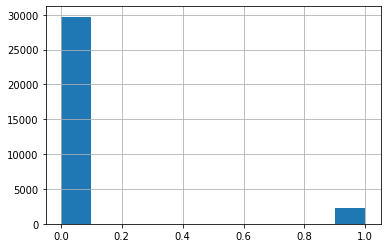

In [ ]:
dataset['label'].hist()

In [ ]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

In [ ]:
## The following preprocessing steps are implemented:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # removal of capitalization
    tweet_lower = punc_remove.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
dataset

,id,label,tweet,processed_tweets
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct run
1,2,0,@user @user thanks for #lyft credit i can't us...,thank lyft credit use caus offer wheelchair va...
2,3,0,bihday your majesty,bihday majesti
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguid societi motiv
...,...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...,ate isz youuu
31958,31959,0,to see nina turner on the airwaves trying to...,see nina turner airwav tri wrap mantl genuin h...
31959,31960,0,listening to sad songs on a monday morning otw...,listen sad song monday morn otw work sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...",sikh templ vandalis calgari wso condemn act


In [ ]:
df = panda.DataFrame(dataset, columns = ['processed_tweets', 'label'])
df

,processed_tweets,label
0,father dysfunct selfish drag kid dysfunct run,0
1,thank lyft credit use caus offer wheelchair va...,0
2,bihday majesti,0
3,model love u take u time ur,0
4,factsguid societi motiv,0
...,...,...
31957,ate isz youuu,0
31958,see nina turner airwav tri wrap mantl genuin h...,0
31959,listen sad song monday morn otw work sad,0
31960,sikh templ vandalis calgari wso condemn act,1


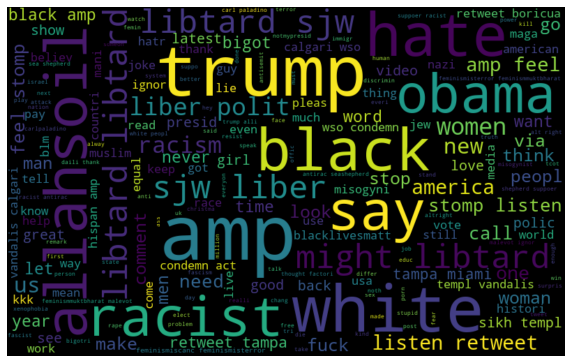

In [ ]:
# visualizing which of the word is most commonly used for hate speech
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

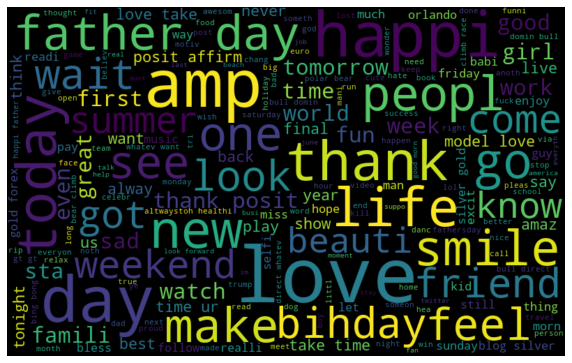

In [ ]:
# visualizing which of the word is most commonly used for non-hate speech
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['label'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

##Logistic Regression


In [ ]:
train, test = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)

In [ ]:
cv= CountVectorizer(binary=True, min_df = 10, max_df = 0.95)
cv.fit_transform(train['processed_tweets'].values)
train_feature_set=cv.transform(train['processed_tweets'].values)
test_feature_set=cv.transform(test['processed_tweets'].values)

In [ ]:
y_train = train['label'].values
y_test = test['label'].values

In [ ]:
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test, y_pred),3))
print("Recall: ",round(metrics.recall_score(y_test, y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.958
Precision:  0.819
Recall:  0.507
F1:  0.626


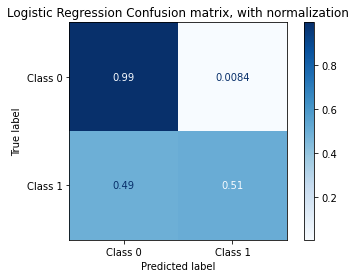

In [ ]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

## Using Random Oversampling with Logistic Regression

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
train, test = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)

In [ ]:
cv= CountVectorizer(binary=True, min_df = 10, max_df = 0.95)
cv.fit_transform(train['processed_tweets'].values)
train_feature_set=cv.transform(train['processed_tweets'].values)
test_feature_set=cv.transform(test['processed_tweets'].values)

In [ ]:
# define oversampling strategy
oversample = RandomOverSampler(random_state=42)

In [ ]:
X = train_feature_set
y = train['label']
X_mod, y_mod = oversample.fit_sample(X, y)

In [ ]:
y_train = train['label'].values
y_test = test['label'].values

In [ ]:
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(X_mod,y_mod)
y_pred = lr.predict(test_feature_set)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test, y_pred),3))
print("Recall: ",round(metrics.recall_score(y_test, y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.917
Precision:  0.445
Recall:  0.748
F1:  0.558


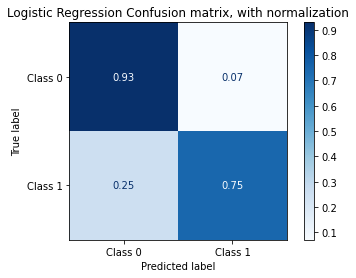

In [ ]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

##Using SMOTE With Logistic Regression

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
train, test = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)

In [ ]:
cv= CountVectorizer(binary=True, min_df = 10, max_df = 0.95)
cv.fit_transform(train['processed_tweets'].values)
train_feature_set=cv.transform(train['processed_tweets'].values)
test_feature_set=cv.transform(test['processed_tweets'].values)

In [ ]:
# define oversampling strategy
smote = SMOTE(random_state=42)

In [ ]:
X = train_feature_set
y = train['label']
X_mod, y_mod = smote.fit_sample(X, y)

In [ ]:
y_train = train['label'].values
y_test = test['label'].values

In [ ]:
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(X_mod,y_mod)
y_pred = lr.predict(test_feature_set)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test, y_pred),3))
print("Recall: ",round(metrics.recall_score(y_test, y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.899
Precision:  0.378
Recall:  0.685
F1:  0.487


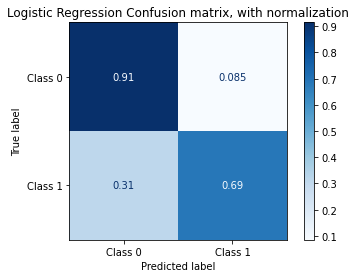

In [ ]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

##Using ADASYN With Logistic Regression

In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
train, test = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)

In [ ]:
cv= CountVectorizer(binary=True, min_df = 10, max_df = 0.95)
cv.fit_transform(train['processed_tweets'].values)
train_feature_set=cv.transform(train['processed_tweets'].values)
test_feature_set=cv.transform(test['processed_tweets'].values)

In [ ]:
# define oversampling strategy
adasyn = ADASYN(random_state=42)

In [ ]:
X = train_feature_set
y = train['label']
X_mod, y_mod = adasyn.fit_sample(X, y)

In [ ]:
y_train = train['label'].values
y_test = test['label'].values

In [ ]:
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(X_mod,y_mod)
y_pred = lr.predict(test_feature_set)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test, y_pred),3))
print("Recall: ",round(metrics.recall_score(y_test, y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.892
Precision:  0.358
Recall:  0.683
F1:  0.47


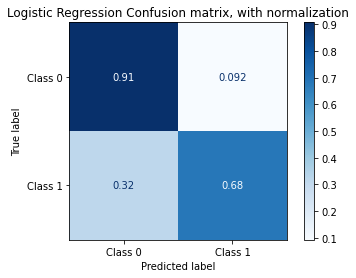

In [ ]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

##Naive Bayes

In [ ]:
train, test = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)

In [ ]:
cv= CountVectorizer(binary=True, min_df = 10, max_df = 0.95)
cv.fit_transform(train['processed_tweets'].values)
train_feature_set=cv.transform(train['processed_tweets'].values)
test_feature_set=cv.transform(test['processed_tweets'].values)

In [ ]:
y_train = train['label'].values
y_test = test['label'].values

In [ ]:
MNB = MultinomialNB()
MNB.fit(train_feature_set,y_train)
y_pred = MNB.predict(test_feature_set)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test, y_pred),3))
print("Recall: ",round(metrics.recall_score(y_test, y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.946
Precision:  0.612
Recall:  0.616
F1:  0.614


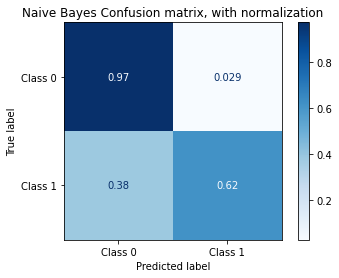

In [ ]:
disp = metrics.plot_confusion_matrix(MNB, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Naive Bayes Confusion matrix, with normalization');

##Using Random Oversampling with Naive Bayes

In [ ]:
train, test = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)

In [ ]:
cv= CountVectorizer(binary=True, min_df = 10, max_df = 0.95)
cv.fit_transform(train['processed_tweets'].values)
train_feature_set=cv.transform(train['processed_tweets'].values)
test_feature_set=cv.transform(test['processed_tweets'].values)

In [ ]:
# define oversampling strategy
oversample = RandomOverSampler(random_state=42)

In [ ]:
X = train_feature_set
y = train['label']
X_mod, y_mod = oversample.fit_sample(X, y)

In [ ]:
y_train = train['label'].values
y_test = test['label'].values

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_mod,y_mod)
y_pred = MNB.predict(test_feature_set)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test, y_pred),3))
print("Recall: ",round(metrics.recall_score(y_test, y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.895
Precision:  0.382
Recall:  0.804
F1:  0.518


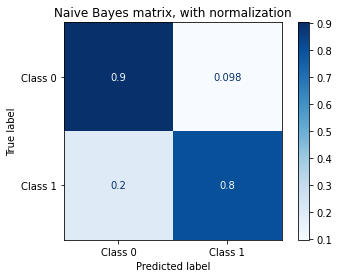

In [ ]:
disp = metrics.plot_confusion_matrix(MNB, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Naive Bayes matrix, with normalization');

##Using SMOTE with Naive Bayes

In [ ]:
train, test = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)

In [ ]:
smote = SMOTE(random_state=42)

In [ ]:
X = train_feature_set
y = train['label']
X_mod, y_mod = smote.fit_sample(X, y)

In [ ]:
y_train = train['label'].values
y_test = test['label'].values

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_mod,y_mod)
y_pred = MNB.predict(test_feature_set)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test, y_pred),3))
print("Recall: ",round(metrics.recall_score(y_test, y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.939
Precision:  0.559
Recall:  0.636
F1:  0.595


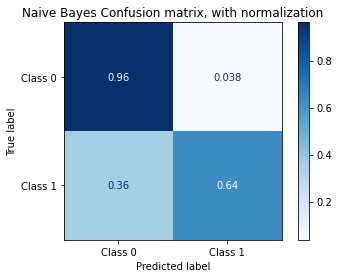

In [ ]:
disp = metrics.plot_confusion_matrix(MNB, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Naive Bayes Confusion matrix, with normalization');

##Using ADASYN with Naive Bayes

In [ ]:
train, test = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)

In [ ]:
adasyn = ADASYN()

In [ ]:
X = train_feature_set
y = train['label']
X_mod, y_mod = adasyn.fit_sample(X, y)

In [ ]:
y_train = train['label'].values
y_test = test['label'].values

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_mod,y_mod)
y_pred = MNB.predict(test_feature_set)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("Precision: ",round(metrics.precision_score(y_test, y_pred),3))
print("Recall: ",round(metrics.recall_score(y_test, y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.904
Precision:  0.405
Recall:  0.786
F1:  0.535


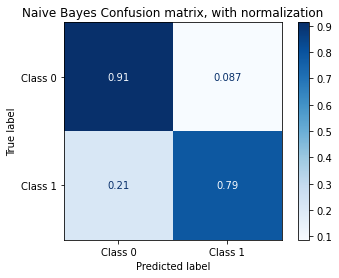

In [ ]:
disp = metrics.plot_confusion_matrix(MNB, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Naive Bayes Confusion matrix, with normalization');